## Logistic regression and Propensity score matching

   
You are provided with data on Armenian Labor Market for 2012 (female data only, Yerevan only). 

1.	To start with provide data description, plot a figure that would provide info whether women having children of 6 or younger are more active in labor marketn than other women (you decide on the type of figure that would communicate such info). 

2.	Run a logistic regression that would predict the labor market activity (being active (employed or unemployed) or inactive (out of labor force) probability of the female based on the characteristics provided in the dataset. Obtain the odds ratios and comment on them. 

3.	In 2011 Yerevan city hall issued a decree that was prescribing all kindergartens to be free for residents of Yerevan. Other things being equal, one would expect that women should be able to enter job market, become active on the job market (that is either employed or unemployed).  Now estimate the effect of treatment (in this case having a child of 6 and younger) on activity of women in labor market (outcome variable), using propensity score matching. Given this, does the provision of free childcare in Yerevan in 2011 had an effect on labor market outcomes of women in 2012. Comment on the result that you obtain. You must use propensity score matching technique, where your outcome variable (y) is being active or not, treatment variable (D) is treat1 (see variable descriptions below), and other variables are your X vector. 


In [64]:
#This is the code that will load the dataset you need. 

In [65]:
#Import basic libariaries
%matplotlib inline
import math
import numpy as np
import scipy
from scipy.stats import binom, hypergeom
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

Variable descriptions: education - varies from 1 to 9, with 9 being highest level; marital = 1.married, 2.never married, 3.widowed, 4.divorced (mostly you have 1 or 2); poverty = 1.non-poor, 2.poor, 3.very poor; headsex = Gender of household head = 1. male, 2.female; headeduc= educaiton level of household head. Active=1 if the woman is active on labor market (employed or unemployed) and Active=0 if the woman is inactive (not participating in labor force). Treat1 = 1, means a woman has child under 6 years old and lives in Yerevan, Treat1=0, means a woman has no child under 6 years old and lives in Yerevan. 

In [66]:
df=pd.read_excel('data_logit_psm_ready.xls')

In [67]:
#Please load all the other libraries as you find them necessary for your assignment!. Good luck!!!

In [68]:
# Data Imports
from pandas import Series,DataFrame

# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# For evaluating our ML results
from sklearn import metrics

# Dataset Import
import statsmodels.api as sm

### Answer to question 1

In [69]:
df.head()

,age,education,marital,poverty,headsex,headeduc,active,treat1
0,32,5,1.0,1,1.0,5.0,1,1
1,53,5,3.0,2,2.0,5.0,1,1
2,53,5,3.0,3,1.0,3.0,1,1
3,51,7,1.0,1,1.0,7.0,1,1
4,49,5,1.0,1,1.0,5.0,1,1


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4536 entries, 0 to 4535
Data columns (total 8 columns):
age          4536 non-null int64
education    4536 non-null int64
marital      4478 non-null float64
poverty      4536 non-null int64
headsex      4445 non-null float64
headeduc     4445 non-null float64
active       4536 non-null int64
treat1       4536 non-null int64
dtypes: float64(3), int64(5)
memory usage: 283.6 KB


In [71]:
#drop missing values
df.dropna(inplace=True)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4388 entries, 0 to 4535
Data columns (total 8 columns):
age          4388 non-null int64
education    4388 non-null int64
marital      4388 non-null float64
poverty      4388 non-null int64
headsex      4388 non-null float64
headeduc     4388 non-null float64
active       4388 non-null int64
treat1       4388 non-null int64
dtypes: float64(3), int64(5)
memory usage: 308.5 KB


In [73]:
df['active'].value_counts()

1    2212
0    2176
Name: active, dtype: int64

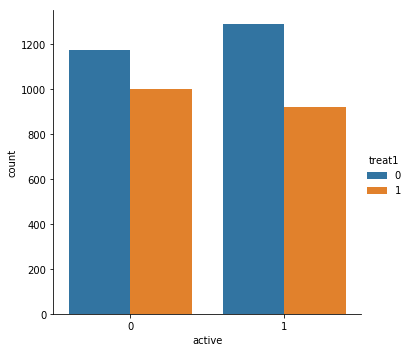

In [74]:
#Investigate age distribution for those who had and didn't have an affair while married. 
sns.catplot('active',data=df,hue='treat1',kind='count')

From the graph it is apparent, that woman who have child under 6 years old are more active in labor market, that is employed or unemployed

### Answer to question 2

In [75]:
#Create dummies for categorical variables

educ_dummies = pd.get_dummies(df['education'], drop_first=True)
poverty_dummies = pd.get_dummies(df['poverty'], drop_first=True)
marital_dummies = pd.get_dummies(df['marital'], drop_first=True)
headsex_dummies = pd.get_dummies(df['headsex'], drop_first=True)


In [76]:
df['headeduc'].value_counts()

5.0     1439
9.0     1225
7.0     1099
4.0      308
6.0      126
3.0       82
8.0       44
10.0      34
1.0       20
2.0       11
Name: headeduc, dtype: int64

In [77]:
educ_dummies.columns = ['e2','e3','e4','e5','e6','e7','e8','e9','e10']
poverty_dummies.columns = ['p2','p3']
marital_dummies.columns = ['m2','m3','m4','m5']
headsex_dummies.columns = ['hs2']

In [78]:
X = df.drop(['education','poverty','marital','headsex','active'],axis=1)
X.head()

,age,headeduc,treat1
0,32,5.0,1
1,53,5.0,1
2,53,3.0,1
3,51,7.0,1
4,49,5.0,1


In [79]:
dummies = pd.concat([educ_dummies,poverty_dummies,marital_dummies,headsex_dummies],axis=1)

In [80]:
X = pd.concat([X,dummies],axis=1)
Y = df.active
X.head()

,age,headeduc,treat1,e2,e3,e4,e5,e6,e7,e8,e9,e10,p2,p3,m2,m3,m4,m5,hs2
0,32,5.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,53,5.0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
2,53,3.0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
3,51,7.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,49,5.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [81]:
logit = sm.Logit(Y,X)
result = logit.fit()
print (result.summary())

         Current function value: 0.623037
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 active   No. Observations:                 4388
Model:                          Logit   Df Residuals:                     4369
Method:                           MLE   Df Model:                           18
Date:                Thu, 16 May 2019   Pseudo R-squ.:                  0.1011
Time:                        16:22:39   Log-Likelihood:                -2733.9
converged:                      False   LL-Null:                       -3041.4
                                        LLR p-value:                5.807e-119
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0067      0.003     -2.639      0.008      -0.012      -0.002
headeduc      -0.1029      0.021     -4.981      0.000      -0.14

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [82]:
print (round((np.exp(result.params))))

age         1.0
headeduc    1.0
treat1      1.0
e2          0.0
e3          0.0
e4          0.0
e5          1.0
e6          3.0
e7          3.0
e8          0.0
e9          6.0
e10         9.0
p2          1.0
p3          1.0
m2          2.0
m3          1.0
m4          3.0
m5          1.0
hs2         1.0
dtype: float64


From the odds ratio we can see that woman we e10 is 9 times more likely to have a job than e1, which is also a significant variable

### Answer to question 3

In [84]:
from causalinference import CausalModel

In [85]:
X.columns

Index(['age', 'headeduc', 'treat1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8',
       'e9', 'e10', 'p2', 'p3', 'm2', 'm3', 'm4', 'm5', 'hs2'],
      dtype='object')

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


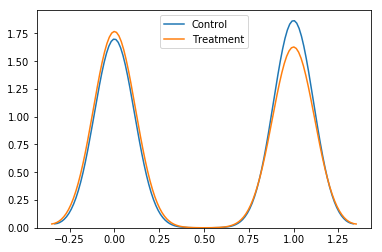

In [90]:
sns.kdeplot(df[df.treat1 == 0].active, label='Control')
sns.kdeplot(df[df.treat1 == 1].active, label='Treatment')

In [87]:
causal_model = CausalModel(
    X=X[['age', 'headeduc', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8',
       'e9', 'e10', 'p2', 'p3', 'm2', 'm3', 'm4', 'm5', 'hs2']].values,
    D=df.treat1.values,
    Y=df.active.values
)
causal_model.est_propensity()
causal_model.trim_s()
causal_model.stratify_s()
causal_model.est_via_ols()
causal_model.est_via_matching(bias_adj=True)
causal_model.est_via_weighting()

print(causal_model.summary_stats)
print(causal_model.estimates)
print(causal_model.propensity)
print(causal_model.strata)

/anaconda3/lib/python3.7/site-packages/causalinference/core/summary.py:110: RuntimeWarning: invalid value encountered in true_divide
  return (mean_t-mean_c) / np.sqrt((sd_c**2+sd_t**2)/2)
/anaconda3/lib/python3.7/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                      Controls (N_c=2421)        Treated (N_t=1909)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.523        0.500        0.479        0.500       -0.044

                      Controls (N_c=2421)        Treated (N_t=1909)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       43.271       16.973       39.908       15.780       -0.205
             X1        6.600        1.928        6.558        1.802       -0.022
             X2        0.000        0.020        0.001        0.023        0.005
             X3        0.006        0.076        0.004        0.060       -0.031
             X4        0.057        0.232        0.046        0.210       -0.049
      

/anaconda3/lib/python3.7/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef
/anaconda3/lib/python3.7/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


#### I run three models and see negative treatment effects in each one; meaning that the provision of free childcare in Yerevan had a negative effect in woman's labor market participation.This can be explained by the fact that woman mostly work for being able to pay for the childcare. However, only 1 ATE score is "significant", which actually is in the borderline of being considered significant.